In [ ]:
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import plotly.express as px
from dash import no_update


# Create a dash application
app = dash.Dash(__name__)

# REVIEW1: Clear the layout and do not display exception till callback gets executed
app.config.suppress_callback_exceptions = True

# Read the airline data into pandas dataframe
airline_data =  pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/airline_data.csv', 
                            encoding = "ISO-8859-1",
                            dtype={'Div1Airport': str, 'Div1TailNum': str, 
                                   'Div2Airport': str, 'Div2TailNum': str})


# List of years 
year_list = [i for i in range(2005, 2021, 1)]

"""Compute graph data for creating yearly airline performance report 
Function that takes airline data as input and create 5 dataframes based on the grouping condition to be used for plottling charts and grphs.
Argument:
     
    df: Filtered dataframe
    
Returns:
   Dataframes to create graph. 
"""
def compute_data_choice_1(df):
    # Cancellation Category Count
    bar_data = df.groupby(['Month','CancellationCode'])['Flights'].sum().reset_index()
    # Average flight time by reporting airline
    line_data = df.groupby(['Month','Reporting_Airline'])['AirTime'].mean().reset_index()
    # Diverted Airport Landings
    div_data = df[df['DivAirportLandings'] != 0.0]
    # Source state count
    map_data = df.groupby(['OriginState'])['Flights'].sum().reset_index()
    # Destination state count
    tree_data = df.groupby(['DestState', 'Reporting_Airline'])['Flights'].sum().reset_index()
    return bar_data, line_data, div_data, map_data, tree_data


"""Compute graph data for creating yearly airline delay report
This function takes in airline data and selected year as an input and performs computation for creating charts and plots.
Arguments:
    df: Input airline data.
    
Returns:
    Computed average dataframes for carrier delay, weather delay, NAS delay, security delay, and late aircraft delay.
"""
def compute_data_choice_2(df):
    # Compute delay averages
    avg_car = df.groupby(['Month','Reporting_Airline'])['CarrierDelay'].mean().reset_index()
    avg_weather = df.groupby(['Month','Reporting_Airline'])['WeatherDelay'].mean().reset_index()
    avg_NAS = df.groupby(['Month','Reporting_Airline'])['NASDelay'].mean().reset_index()
    avg_sec = df.groupby(['Month','Reporting_Airline'])['SecurityDelay'].mean().reset_index()
    avg_late = df.groupby(['Month','Reporting_Airline'])['LateAircraftDelay'].mean().reset_index()
    return avg_car, avg_weather, avg_NAS, avg_sec, avg_late


# Application layout
app.layout = html.Div(children=[ 
                                # TASK1: Add title to the dashboard
                                # Enter your code below. Make sure you have correct formatting.
                                html.H1('US Domestic Airline Flights Performance', style={'textAlign':'center', 'color':'#503D36', 'font-size': 24}),
                                # REVIEW2: Dropdown creation
                                # Create an outer division 
                                html.Div([
                                    # Add an division
                                    html.Div([
                                        # Create an division for adding dropdown helper text for report type
                                        html.Div(
                                            [
                                            html.H2('Report Type:', style={'margin-right': '2em'}),
                                            ]
                                        ),
                                        # TASK2: Add a dropdown
                                        # Enter your code below. Make sure you have correct formatting.
                                        dcc.Dropdown(id='input-type', 
                                                    options=[
                                                            {'label': 'Yearly Airline Performance Report', 'value': 'OPT1'},
                                                            {'label': 'Yearly Airline Delay Report', 'value': 'OPT2'}],
                                                    placeholder='Select a report type',
                                                    style={'width':'80%', 'padding':'3px', 'font-size': '20px', 'text-align-last' : 'center'}),
                                    # Place them next to each other using the division style
                                    ], style={'display':'flex'}),
                                    
                                   # Add next division 
                                   html.Div([
                                       # Create an division for adding dropdown helper text for choosing year
                                        html.Div(
                                            [
                                            html.H2('Choose Year:', style={'margin-right': '2em'})
                                            ]
                                        ),
                                        dcc.Dropdown(id='input-year', 
                                                     # Update dropdown values using list comphrehension
                                                     options=[{'label': i, 'value': i} for i in year_list],
                                                     placeholder="Select a year",
                                                     style={'width':'80%', 'padding':'3px', 'font-size': '20px', 'text-align-last' : 'center'}),
                                            # Place them next to each other using the division style
                                            ], style={'display': 'flex'}),  
                                          ]),
                                
                                # Add Computed graphs
                                # REVIEW3: Observe how we add an empty division and providing an id that will be updated during callback
                                html.Div([ ], id='plot1'),
    
                                html.Div([
                                        html.Div([ ], id='plot2'),
                                        html.Div([ ], id='plot3')
                                ], style={'display': 'flex'}),
                                
                                # TASK3: Add a division with two empty divisions inside. See above disvision for example.
                                # Enter your code below. Make sure you have correct formatting.
                                html.Div([
                                        html.Div([ ], id='plot4'),
                                        html.Div([ ], id='plot5')
                                ], style={'display': 'flex'}),
                                ])

# Callback function definition
# TASK4: Add 5 ouput components
# Enter your code below. Make sure you have correct formatting.
@app.callback( [Output(component_id='plot1', component_property='children'),
                Output(component_id='plot2', component_property='children'),
                Output(component_id='plot3', component_property='children'),
                Output(component_id='plot4', component_property='children'),
                Output(component_id='plot5', component_property='children')],
               [Input(component_id='input-type', component_property='value'),
                Input(component_id='input-year', component_property='value')],
               # REVIEW4: Holding output state till user enters all the form information. In this case, it will be chart type and year
               [State("plot1", 'children'), State("plot2", "children"),
                State("plot3", "children"), State("plot4", "children"),
                State("plot5", "children")
               ])
# Add computation to callback function and return graph
def get_graph(chart, year, children1, children2, c3, c4, c5):
      
        # Select data
        df =  airline_data[airline_data['Year']==int(year)]
       
        if chart == 'OPT1':
            # Compute required information for creating graph from the data
            bar_data, line_data, div_data, map_data, tree_data = compute_data_choice_1(df)
            
            # Number of flights under different cancellation categories
            bar_fig = px.bar(bar_data, x='Month', y='Flights', color='CancellationCode', title='Monthly Flight Cancellation')
            
            # TASK5: Average flight time by reporting airline
            # Enter your code below. Make sure you have correct formatting.
            line_fig = px.line(line_data, x='Month', y='AirTime', color='Reporting_Airline', title='Average monthly flight time (minutes) by airline')
            
            # Percentage of diverted airport landings per reporting airline
            pie_fig = px.pie(div_data, values='Flights', names='Reporting_Airline', title='% of flights by reporting airline')
            
            # REVIEW5: Number of flights flying from each state using choropleth
            map_fig = px.choropleth(map_data,  # Input data
                    locations='OriginState', 
                    color='Flights',  
                    hover_data=['OriginState', 'Flights'], 
                    locationmode = 'USA-states', # Set to plot as US States
                    color_continuous_scale='GnBu',
                    range_color=[0, map_data['Flights'].max()]) 
            map_fig.update_layout(
                    title_text = 'Number of flights from origin state', 
                    geo_scope='usa') # Plot only the USA instead of globe
            
            # TASK6: Number of flights flying to each state from each reporting airline
            # Enter your code below. Make sure you have correct formatting.
            tree_fig = px.treemap(tree_data, 
                        path=['DestState', 'Reporting_Airline'], 
                        values= 'Flights', 
                        color='Flights', 
                        color_continuous_scale='RdBu',
                        title='Flight count by airline to destination state')
            
            
            # REVIEW6: Return dcc.Graph component to the empty division
            return [dcc.Graph(figure=tree_fig), 
                    dcc.Graph(figure=pie_fig),
                    dcc.Graph(figure=map_fig),
                    dcc.Graph(figure=bar_fig),
                    dcc.Graph(figure=line_fig)
                   ]
        else:
            # REVIEW7: This covers chart type 2 and we have completed this exercise under Flight Delay Time Statistics Dashboard section
            # Compute required information for creating graph from the data
            avg_car, avg_weather, avg_NAS, avg_sec, avg_late = compute_data_choice_2(df)
            
            # Create graph
            carrier_fig = px.line(avg_car, x='Month', y='CarrierDelay', color='Reporting_Airline', title='Average carrrier delay time (minutes) by airline')
            weather_fig = px.line(avg_weather, x='Month', y='WeatherDelay', color='Reporting_Airline', title='Average weather delay time (minutes) by airline')
            nas_fig = px.line(avg_NAS, x='Month', y='NASDelay', color='Reporting_Airline', title='Average NAS delay time (minutes) by airline')
            sec_fig = px.line(avg_sec, x='Month', y='SecurityDelay', color='Reporting_Airline', title='Average security delay time (minutes) by airline')
            late_fig = px.line(avg_late, x='Month', y='LateAircraftDelay', color='Reporting_Airline', title='Average late aircraft delay time (minutes) by airline')
            
            return[dcc.Graph(figure=carrier_fig), 
                   dcc.Graph(figure=weather_fig), 
                   dcc.Graph(figure=nas_fig), 
                   dcc.Graph(figure=sec_fig), 
                   dcc.Graph(figure=late_fig)]


# Run the app
if __name__ == '__main__':
    app.run_server()

In [10]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1)

fig.add_scatter(y=[4, 2, 1], mode="lines", row=1, col=1)
fig.add_bar(y=[2, 1, 3], row=2, col=1)
fig.update_layout(
    autosize=False,
    width=1000,
    height=2000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

In [13]:
fig.write_image("./fig1.jpeg")

In [3]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_iris()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a reinforcement learning agent
class RLAgent:
    def __init__(self):
        self.model = SGDClassifier(loss='log', max_iter=100)

    def act(self, state):
        # Perform an action based on the current state
        action = self.model.predict(state)
        return action

    def train(self, state, action, reward, next_state):
        # Update the agent's model based on the reward
        self.model.partial_fit(state, action, classes=np.unique(action))

# Create an instance of the RL agent
agent = RLAgent()

# Train the agent using the dataset
for i in range(len(X_train)):
    state = X_train[i].reshape(1, -1)
    action = y_train[i]
    reward = 1 if agent.act(state) == action else -1
    next_state = X_train[i+1].reshape(1, -1) if i < len(X_train) - 1 else None

    agent.train(state, action, reward, next_state)

# Evaluate the agent's performance on the test set
predictions = []
for i in range(len(X_test)):
    state = X_test[i].reshape(1, -1)
    action = agent.act(state)
    predictions.append(action)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


NotFittedError: This SGDClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [4]:
# the code show NotFittedError: This SGDClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_iris()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a reinforcement learning agent
class RLAgent:
    def __init__(self):
        self.model = SGDClassifier(loss='log', max_iter=100)

    def act(self, state):
        # Perform an action based on the current state
        action = self.model.predict(state)
        return action

    def train(self, state, action, reward, next_state):
        # Update the agent's model based on the reward
        self.model.partial_fit(state, action, classes=np.unique(action))

# Create an instance of the RL agent
agent = RLAgent()

# Fit the model before training the agent
agent.model.fit(X_train, y_train)

# Train the agent using the dataset
for i in range(len(X_train)):
    state = X_train[i].reshape(1, -1)
    action = y_train[i]
    reward = 1 if agent.act(state) == action else -1
    next_state = X_train[i+1].reshape(1, -1) if i < len(X_train) - 1 else None

    agent.train(state, action, reward, next_state)

# Evaluate the agent's performance on the test set
predictions = []
for i in range(len(X_test)):
    state = X_test[i].reshape(1, -1)
    action = agent.act(state)
    predictions.append(action)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


ValueError: y should be a 1d array, got an array of shape () instead.

In [6]:
# this code line: "agent.train(state, action, reward, next_state)" show error about ValueError: y should be a 1d array, got an array of shape () instead.

In [7]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_iris()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a reinforcement learning agent
class RLAgent:
    def __init__(self):
        self.model = SGDClassifier(loss='log', max_iter=100)

    def act(self, state):
        # Perform an action based on the current state
        action = self.model.predict(state)
        return action

    def train(self, state, action, reward, next_state):
        # Update the agent's model based on the reward
        self.model.partial_fit(state, [action], classes=np.unique(action))

# Create an instance of the RL agent
agent = RLAgent()

# Fit the model before training the agent
agent.model.fit(X_train, y_train)

# Train the agent using the dataset
for i in range(len(X_train)):
    state = X_train[i].reshape(1, -1)
    action = y_train[i]
    reward = 1 if agent.act(state) == action else -1
    next_state = X_train[i+1].reshape(1, -1) if i < len(X_train) - 1 else None

    agent.train(state, action, reward, next_state)

# Evaluate the agent's performance on the test set
predictions = []
for i in range(len(X_test)):
    state = X_test[i].reshape(1, -1)
    action = agent.act(state)
    predictions.append(action)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


ValueError: `classes=array([0])` is not the same as on last call to partial_fit, was: array([0, 1, 2])

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_iris()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a reinforcement learning agent
class RLAgent:
    def __init__(self):
        self.model = SGDClassifier(loss='log', max_iter=100)
        self.classes_seen = np.array([])

    def act(self, state):
        # Perform an action based on the current state
        action = self.model.predict(state)
        return action

    def train(self, state, action, reward, next_state):
        # Update the agent's model based on the reward
        self.classes_seen = np.unique(np.concatenate([self.classes_seen, [action]]))
        self.model.partial_fit(state, [action], classes=self.classes_seen)

# Create an instance of the RL agent
agent = RLAgent()

# Fit the model before training the agent
agent.model.fit(X_train, y_train)

# Train the agent using the dataset
for i in range(len(X_train)):
    state = X_train[i].reshape(1, -1)
    action = y_train[i]
    reward = 1 if agent.act(state) == action else -1
    next_state = X_train[i+1].reshape(1, -1) if i < len(X_train) - 1 else None

    agent.train(state, action, reward, next_state)

# Evaluate the agent's performance on the test set
predictions = []
for i in range(len(X_test)):
    state = X_test[i].reshape(1, -1)
    action = agent.act(state)
    predictions.append(action)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


ValueError: `classes=array([0.])` is not the same as on last call to partial_fit, was: array([0, 1, 2])

In [9]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Load the iris dataset
iris = load_iris()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a reinforcement learning agent
class RLAgent:
    def __init__(self):
        self.model = SGDClassifier(loss='log', max_iter=100)
        self.classes_seen = np.array([])
        self.actions = []

    def act(self, state):
        # Perform an action based on the current state
        action = self.model.predict(state)
        return action

    def train(self, state, action, reward, next_state):
        # Update the agent's model based on the reward
        self.actions.append(action)
        self.classes_seen = np.unique(self.actions)
        self.model.partial_fit(state, self.actions, classes=self.classes_seen)

# Create an instance of the RL agent
agent = RLAgent()

# Fit the model before training the agent
agent.model.fit(X_train, y_train)

# Train the agent using the dataset
for i in range(len(X_train)):
    state = X_train[i].reshape(1, -1)
    action = y_train[i]
    reward = 1 if agent.act(state) == action else -1
    next_state = X_train[i+1].reshape(1, -1) if i < len(X_train) - 1 else None

    agent.train(state, action, reward, next_state)

# Evaluate the agent's performance on the test set
predictions = []
for i in range(len(X_test)):
    state = X_test[i].reshape(1, -1)
    action = agent.act(state)
    predictions.append(action)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


ValueError: `classes=array([0])` is not the same as on last call to partial_fit, was: array([0, 1, 2])

In [6]:
import sklearn

C:\Users\AI\anaconda3\envs\startup\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\AI\anaconda3\envs\startup\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\AI\anaconda3\envs\startup\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [7]:
print(sklearn.__version__)

1.3.0


In [1]:
# pip install --upgrade scikit-learn

In [2]:
# pip install --upgrade numpy

In [3]:
# pip install --upgrade threadpoolctl

In [4]:
# pip install --upgrade scipy

In [8]:
# pip install --upgrade scikit-learn

In [9]:
>>> from sklearn.neural_network import MLPClassifier
>>> from sklearn.datasets import make_classification
>>> from sklearn.model_selection import train_test_split
>>> X, y = make_classification(n_samples=100, random_state=1)
>>> X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
>>> clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
>>> clf.predict_proba(X_test[:1])

>>> clf.predict(X_test[:5, :])

>>> clf.score(X_test, y_test)


0.88

In [11]:
X_train.shape

(75, 20)

In [12]:
y_train.shape

(75,)

In [13]:
y_train

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0])

In [ ]:
# 神经网络(深度学习)----MLPClassifier库的初尝试
# https://blog.csdn.net/weixin_43479947/article/details/126869972 

In [85]:
from sklearn.datasets import load_breast_cancer               #引入数据集
from sklearn.neural_network import MLPClassifier              #引入MLP神经网络分类器
from sklearn.model_selection import train_test_split          #引入数据集分割函数

cancer = load_breast_cancer()                                  #加载数据集
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)           #拆分数据集

mlp = MLPClassifier(random_state=42)                           #加载神经网络模型
mlp.fit(X_train, y_train)                                      #训练数据集

print('Accuracy on training set:{}'.format(mlp.score(X_train, y_train)))                              #输出训练集预测准确度
print('Accuracy on test set:{}'.format(mlp.score(X_test, y_test)))                                    #输出测试集预测准确度


Accuracy on training set:0.9389671361502347
Accuracy on test set:0.916083916083916


In [15]:
mean_on_training = X_train.mean(axis=0)                            #求每一列特征的平均值
std_on_training = X_train.std(axis=0)                              #求每一列特征的标准差

#training_scale数据集中的特征列均值为0，标准差为1
X_training_scale = (X_train-mean_on_training)/std_on_training        #数据集减去每个特征的均值。再除以标准差
X_test_scale = (X_test-mean_on_training)/std_on_training             #同样地对测试集数据进行测试

mlp = MLPClassifier(random_state=42)                                 #加载神经网络模型
mlp.fit(X_training_scale, y_train)                                   #训练数据集

print('Accuracy on training set:{}'.format(mlp.score(X_training_scale, y_train)))             #输出训练集预测准确度
print('Accuracy on test set:{}'.format(mlp.score(X_test_scale, y_test)))                      #输出测试集预测准确度


Accuracy on training set:0.9929577464788732
Accuracy on test set:0.965034965034965


C:\Users\AI\anaconda3\envs\startup\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [86]:
mean_on_training = X_train.mean(axis=0)                            #求每一列特征的平均值
std_on_training = X_train.std(axis=0)                              #求每一列特征的标准差

#training_scale数据集中的特征列均值为0，标准差为1
X_training_scale = (X_train-mean_on_training)/std_on_training        #数据集减去每个特征的均值。再除以标准差
X_test_scale = (X_test-mean_on_training)/std_on_training             #同样地对测试集数据进行测试

mlp = MLPClassifier(random_state=42, alpha=1)                        #加载神经网络模型, 增加alpha到 1
mlp.fit(X_training_scale, y_train)                                   #训练数据集

print('Accuracy on training set:{}'.format(mlp.score(X_training_scale, y_train)))             #输出训练集预测准确度
print('Accuracy on test set:{}'.format(mlp.score(X_test_scale, y_test)))                      #输出测试集预测准确度


Accuracy on training set:0.9859154929577465
Accuracy on test set:0.9790209790209791


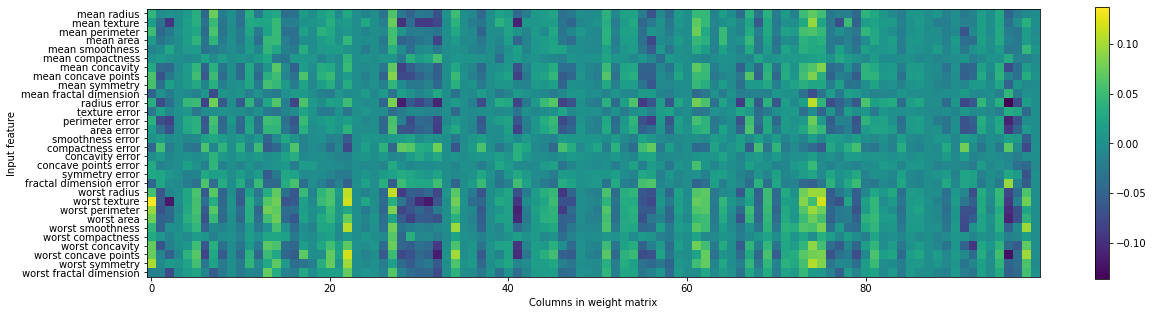

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))                                               #显示面板
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel('Columns in weight matrix')
plt.ylabel('Input feature')
plt.colorbar()


In [83]:
mean_on_training = X_train.mean(axis=0)                            #求每一列特征的平均值
std_on_training = X_train.std(axis=0)                              #求每一列特征的标准差

#training_scale数据集中的特征列均值为0，标准差为1
X_training_scale = (X_train-mean_on_training)/std_on_training        #数据集减去每个特征的均值。再除以标准差
X_test_scale = (X_test-mean_on_training)/std_on_training             #同样地对测试集数据进行测试

mlp = MLPClassifier(random_state=42, alpha=1)                        #加载神经网络模型, 增加alpha到 1
mlp.fit(X_training_scale, y_train)                                   #训练数据集

print('Accuracy on training set:{}'.format(mlp.score(X_training_scale, y_train)))             #输出训练集预测准确度
print('Accuracy on test set:{}'.format(mlp.score(X_test_scale, y_test)))                      #输出测试集预测准确度


Accuracy on training set:0.8666666666666667
Accuracy on test set:0.76


C:\Users\AI\anaconda3\envs\startup\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


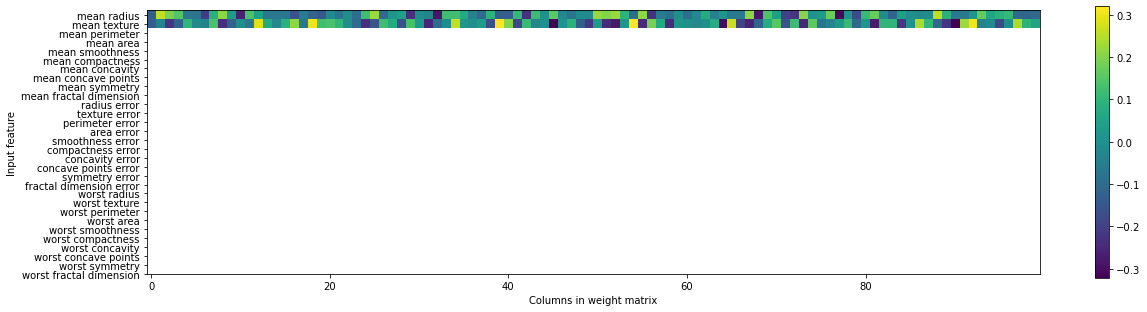

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))                                               #显示面板
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel('Columns in weight matrix')
plt.ylabel('Input feature')
plt.colorbar()


In [65]:
mlp.coefs_[0].shape

(30, 100)

In [88]:
mean_on_training = X_train.mean(axis=0)                            #求每一列特征的平均值
std_on_training = X_train.std(axis=0)                              #求每一列特征的标准差

#training_scale数据集中的特征列均值为0，标准差为1
X_training_scale = (X_train-mean_on_training)/std_on_training        #数据集减去每个特征的均值。再除以标准差
X_test_scale = (X_test-mean_on_training)/std_on_training             #同样地对测试集数据进行测试

mlp = MLPClassifier(random_state=42, alpha=1,hidden_layer_sizes =(100,50,2))                        #加载神经网络模型, 增加alpha到 1
mlp.fit(X_training_scale, y_train)                                   #训练数据集

print('Accuracy on training set:{}'.format(mlp.score(X_training_scale, y_train)))             #输出训练集预测准确度
print('Accuracy on test set:{}'.format(mlp.score(X_test_scale, y_test)))                      #输出测试集预测准确度



Accuracy on training set:0.9906103286384976
Accuracy on test set:0.965034965034965


C:\Users\AI\anaconda3\envs\startup\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


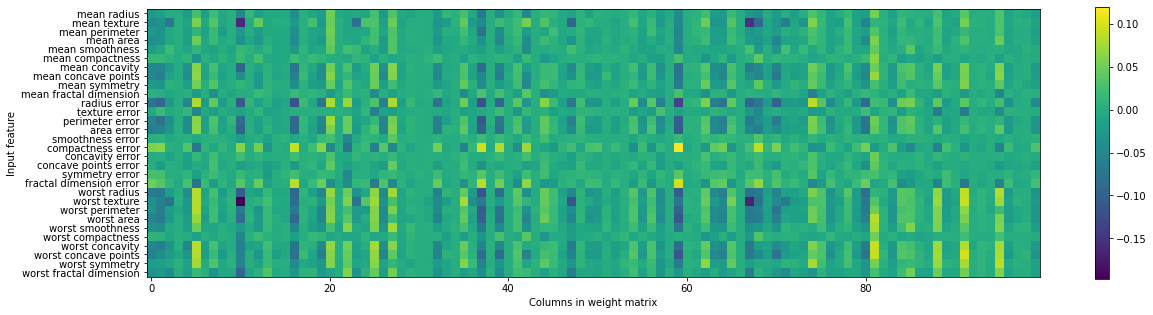

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))                                               #显示面板
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel('Columns in weight matrix')
plt.ylabel('Input feature')
plt.colorbar()


In [99]:
mlp.coefs_[0]

array([[-2.55056645e-02, -1.56239128e-02, -1.42507309e-03, ...,
        -2.22973853e-04, -4.68753022e-03, -1.66518864e-02],
       [-4.47523693e-02, -3.45603926e-02, -6.64788915e-02, ...,
         3.82303061e-03,  1.16054002e-03, -1.15359379e-02],
       [-2.47881561e-02, -3.57149439e-02, -5.47138025e-03, ...,
        -6.18450857e-04, -3.42843461e-06, -1.79187253e-02],
       ...,
       [-5.91641287e-02, -3.88264123e-02, -2.29295788e-02, ...,
         1.10318739e-03,  8.25452586e-03, -3.34942127e-02],
       [-2.09148271e-02, -1.54032043e-02, -6.78645132e-03, ...,
         3.57274088e-03, -1.96648926e-07, -1.56626111e-02],
       [-3.59590956e-02, -2.86605023e-02, -4.25874735e-02, ...,
         5.30984123e-04,  1.00753883e-05, -1.52945273e-02]])

In [100]:
mlp.coefs_[0].shape

(30, 100)

In [102]:
np_tes1= np.std(mlp.coefs_[0],axis =1)

In [103]:
np_tes1.shape

(30,)

In [105]:
np_tes1

array([0.01977133, 0.03601538, 0.01811376, 0.02063665, 0.01469263,
       0.0131437 , 0.03220177, 0.03037399, 0.02215805, 0.01568282,
       0.04640451, 0.01603649, 0.0351477 , 0.03494713, 0.0102692 ,
       0.03669021, 0.01004322, 0.01415324, 0.01327762, 0.03195076,
       0.04127476, 0.04523465, 0.03510437, 0.03697278, 0.02656879,
       0.01353123, 0.03634991, 0.03915921, 0.02830713, 0.02493487])

TypeError: Invalid shape (30,) for image data

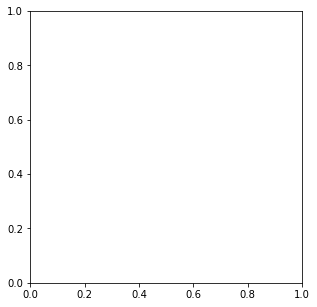

In [104]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,5))                                               #显示面板
# plt.imshow(np_tes1, interpolation='none', cmap='viridis')
# plt.yticks(range(30), cancer.feature_names)
# plt.xlabel('Columns in weight matrix')
# plt.ylabel('Input feature')
# plt.colorbar()

In [ ]:
np_tes1

(100, 50)

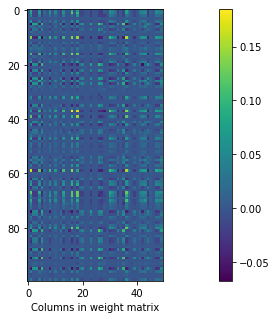

In [96]:
plt.figure(figsize=(20,5))                                               #显示面板
plt.imshow(mlp.coefs_[1], interpolation='none', cmap='viridis')
# plt.yticks(range(30), cancer.feature_names)
plt.xlabel('Columns in weight matrix')
# plt.ylabel('Input feature')
plt.colorbar()
mlp.coefs_[1].shape

(50, 2)

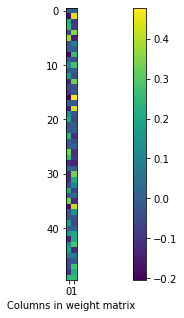

In [98]:
plt.figure(figsize=(20,5))                                               #显示面板
plt.imshow(mlp.coefs_[2], interpolation='none', cmap='viridis')
# plt.yticks(range(30), cancer.feature_names)
plt.xlabel('Columns in weight matrix')
# plt.ylabel('Input feature')
plt.colorbar()
mlp.coefs_[2].shape

In [92]:
mlp.coefs_[2].shape

(50, 2)

In [80]:
# mlp.coefs_[0]

In [25]:
from sklearn.datasets import load_breast_cancer               #引入数据集
from sklearn.neural_network import MLPClassifier              #引入MLP神经网络分类器
from sklearn.model_selection import train_test_split          #引入数据集分割函数

cancer = load_breast_cancer()                                  #加载数据集
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)           #拆分数据集

mlp = MLPClassifier(random_state=42,hidden_layer_sizes =(5,2))                           #加载神经网络模型
mlp.fit(X_train, y_train)                                      #训练数据集

print('Accuracy on training set:{}'.format(mlp.score(X_train, y_train)))                              #输出训练集预测准确度
print('Accuracy on test set:{}'.format(mlp.score(X_test, y_test)))                                    #输出测试集预测准确度


Accuracy on training set:0.9248826291079812
Accuracy on test set:0.9440559440559441


C:\Users\AI\anaconda3\envs\startup\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
mean_on_training = X_train.mean(axis=0)                            #求每一列特征的平均值
std_on_training = X_train.std(axis=0)                              #求每一列特征的标准差

#training_scale数据集中的特征列均值为0，标准差为1
X_training_scale = (X_train-mean_on_training)/std_on_training        #数据集减去每个特征的均值。再除以标准差
X_test_scale = (X_test-mean_on_training)/std_on_training             #同样地对测试集数据进行测试

mlp = MLPClassifier(random_state=42, alpha=1,activation="relu",hidden_layer_sizes = (100,20,20,2))                        #加载神经网络模型, 增加alpha到 1
mlp.fit(X_training_scale, y_train)                                   #训练数据集

print('Accuracy on training set:{}'.format(mlp.score(X_training_scale, y_train)))             #输出训练集预测准确度
print('Accuracy on test set:{}'.format(mlp.score(X_test_scale, y_test)))                      #输出测试集预测准确度


Accuracy on training set:0.9859154929577465
Accuracy on test set:0.972027972027972


C:\Users\AI\anaconda3\envs\startup\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
https://martychen920.blogspot.com/2017/10/ml-mlpclassifier.html

In [52]:
# PYTHON sklearn库降维聚类实战——威斯康辛州乳腺癌数据集聚类
# https://blog.csdn.net/qq_44883083/article/details/90732337

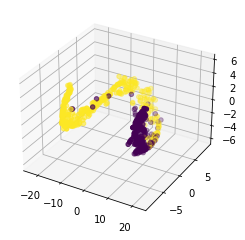

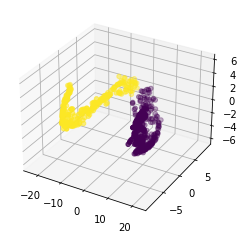

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import random_projection
from sklearn import manifold
from sklearn import decomposition

##乳腺癌数据集
X,y=datasets.load_breast_cancer(return_X_y=True)
##print("X.shape:",X.shape)
##print("y.shape:",y.shape)
##print("X[:3]:",X[:3])
##print("y[:3]",y[:3])

##随机投影降维
##rp=random_projection.SparseRandomProjection(n_components=3,density=0.1,random_state=0)
##X_projected=rp.fit_transform(X)

##T-SNE降维
tsne=manifold.TSNE(n_components=3,init="pca")
X_projected=tsne.fit_transform(X)

##PCA降维
##pca=decomposition.TruncatedSVD(n_components=3)
##X_projected=pca.fit_transform(X)

##Isomap降维
##iso = manifold.Isomap(n_neighbors=20, n_components=3)
#X_projected=iso.fit_transform(X)

##结果标准化
##X_projected=preprocessing.scale(X_projected)

##DBSCAN聚类
##y_pred=DBSCAN(eps=0.1,min_samples=10).fit_predict(X_projected)

##GMM聚类
y_pred=GaussianMixture(n_components=2).fit_predict(X_projected)

##K-means聚类
##y_pred=KMeans(n_clusters=2).fit_predict(X_projected)

##对K-mean的聚类效果进行评分
##score=metrics.calinski_harabasz_score(X_projected,y_pred)
##print(score)

plt.figure(1)
ax = plt.subplot(111, projection='3d')
ax.scatter(X_projected[:,0],X_projected[:,1],X_projected[:,2],c=y)
plt.figure(2)
ax = plt.subplot(111, projection='3d')
ax.scatter(X_projected[:,0],X_projected[:,1],X_projected[:,2],c=y_pred)
plt.show()



In [49]:
X_projected.shape

(569, 3)

In [50]:
X.shape

(569, 30)

In [ ]:
# 【机器学习】04. 神经网络模型 MLPClassifier分类算法与MLPRegressor回归算法（代码注释，思路推导）
# https://blog.csdn.net/u011027547/article/details/127013156

In [ ]:
# 【机器学习】04. 神经网络模型 MLPClassifier分类算法与MLPRegressor回归算法（代码注释，思路推导）
# https://blog.csdn.net/u011027547/article/details/127013156

In [54]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import preprocessing
# orgin_data=pd.read_csv("data1.csv").values
# data=orgin_data[:,0:2]#准备进行模型训练时不需要已知的分类结果，只需要特征1和特征2
# print(data)

# # 2.数据归一化
# # MaxAbsScaler根据最大值的绝对值进行标准化。假设某列原数据为x，则新数据为x/|max|
# # 可以保证特征数据缩放到区间[-1,1]
# max_abs_scaler = preprocessing.MaxAbsScaler()  # 注册一个预处理对象
# sizeOfOne_data = max_abs_scaler.fit_transform(data)  # fit_transform(X[, y])	适合数据，然后转换它。
# print(sizeOfOne_data)


In [55]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import preprocessing
# orgin_data=pd.read_csv("data1.csv").values
# data=orgin_data[:,0:2]#准备进行模型训练时不需要已知的分类结果，只需要特征1和特征2
# print(data)

# # 2.数据归一化
# # MaxAbsScaler根据最大值的绝对值进行标准化。假设某列原数据为x，则新数据为x/|max|
# # 可以保证特征数据缩放到区间[-1,1]
# max_abs_scaler = preprocessing.MaxAbsScaler()  # 注册一个预处理对象
# sizeOfOne_data = max_abs_scaler.fit_transform(data)  # fit_transform(X[, y])	适合数据，然后转换它。
# print(sizeOfOne_data)


In [56]:
# [ 分享 ] Sklearn 中的神经网络 Neural network models
# https://zhuanlan.zhihu.com/p/352330001

In [57]:
# 多層感知器（一）
# https://openhome.cc/Gossip/DCHardWay/MultilayerPerceptron.html

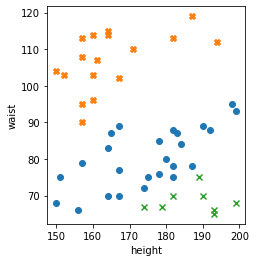

In [58]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('height_waist2.csv', delimiter=',')

height_waist = data[:,0:2]
label = data[:,2]

height = height_waist[:,0]
waist = height_waist[:,1]

normal_weight = label == 0
overweight = label == -1
rundown_weight = label == 1

plt.xlabel('height') 
plt.ylabel('waist')
plt.gca().set_aspect(1)
plt.scatter(height_waist[normal_weight, 0], height_waist[normal_weight, 1], marker = 'o')
plt.scatter(height_waist[overweight, 0], height_waist[overweight, 1], marker = 'X')
plt.scatter(height_waist[rundown_weight, 0], height_waist[rundown_weight, 1], marker = 'x')

plt.show()

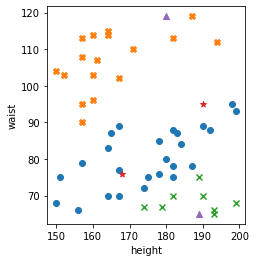

In [59]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron

def scatter(height_waist, label):
    waist = height_waist[:,1]

    normal_weight = label == 0
    overweight = label == -1
    rundown_weight = label == 1

    plt.xlabel('height') 
    plt.ylabel('waist')
    plt.gca().set_aspect(1)
    plt.scatter(height_waist[normal_weight, 0], height_waist[normal_weight, 1], marker = 'o')
    plt.scatter(height_waist[overweight, 0], height_waist[overweight, 1], marker = 'X')
    plt.scatter(height_waist[rundown_weight, 0], height_waist[rundown_weight, 1], marker = 'x')

def perceptron(height_waist, label):
    p = Perceptron()
    p.fit(height_waist, label)
    return p

def height_waist_mlp(height_waist, label):
    # 劃分是否太胖
    # 重新標記，只區分太胖（1）與不胖（0）
    flabel = label.copy()
    flabel[np.where(label == -1)] = 1      # 胖標記為 1
    flabel[np.where(label == 1)] = 0       # 瘦也標為 0
    p1 = perceptron(height_waist, flabel)  # 建立感知器

    # 劃分是否太瘦
    # 重新標記，只區分太瘦（1）與不瘦（0）
    tlabel = label.copy()
    tlabel[np.where(label == 1)] = 1       # 瘦標記為 1
    tlabel[np.where(label == -1)] = 0      # 胖也標為 0
    p2 = perceptron(height_waist, tlabel)  # 建立感知器

    # 劃分是否適中
    nlabel = label.copy()
    # 重新標記，只區分體型不適中（1）與適中（0）
    nlabel[np.where(label != 0)] = 1
    # 兩個感知器的預測結果
    pp_predict = np.dstack((p1.predict(height_waist), p2.predict(height_waist)))[0]
    # 提供給第三個感知器
    p3 = perceptron(pp_predict, nlabel)

    return p1, p2, p3

def predict(mlp, test):
    p1, p2, p3 = mlp
    pp = np.dstack((p1.predict(test), p2.predict(test)))[0]
    return p3.predict(pp)

data = np.loadtxt('height_waist2.csv', delimiter=',')
height_waist = data[:,0:2]
label = data[:,2]

height = height_waist[:,0]
h = np.arange(np.min(height), np.max(height))

scatter(height_waist, label)

mlp = height_waist_mlp(height_waist, label) # 多層感知器
test = np.array([[190, 95], [180, 119], [189, 65], [168, 76]]) # 測試
pd = predict(mlp, test) # 預測

plt.scatter(test[pd == 0, 0], test[pd == 0, 1], marker = '*')
plt.scatter(test[pd == 1, 0], test[pd == 1, 1], marker = '^')

plt.show()

In [60]:
# https://zhuanlan.zhihu.com/p/352330001
#     1.17.8. Tips on Practical Use
# 多层感知器对特征缩放很敏感，因此强烈建议对数据进行缩放。例如，将输入向量X上的每个属性都缩放为[0，1]或[-1，+1]的范围，或将其标准化。需要注意的是，必须对测试集应用相同的缩放比例，从而产生有意义的结果。可以使用StandardScaler用于标准化。

In [61]:
# PYTHON sklearn库降维聚类实战——威斯康辛州乳腺癌数据集聚类
# https://blog.csdn.net/qq_44883083/article/details/90732337

In [106]:
# 小提琴与中提琴协奏——隐藏层节点数为200、层数为2的MLP模型
# https://zhuanlan.zhihu.com/p/150486089

In [ ]:
【第1&2章】ML基础和监督学习算法（附sklearn花式调参）

In [ ]:
# 教程 | 初学者入门：如何用Python和SciKit Learn 0.18实现神经网络？
# https://cloud.tencent.com/developer/article/1117984

In [ ]:

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)